In [1]:
import sys
sys.path.append("/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/scripts/")
from inference_helpers import *

/lustre/fsw/portfolios/nvr/users/mmemmel/miniforge3/envs/vila/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_name = "vila_3b_path_mask"
model_path = "/home/mmemmel/projects/vila/checkpoints/finetuned/"
base_name = None # "Efficient-Large-Model/VILA1.5-3b"
base_path = None
prompt_type = "path_mask" # "mask", "path_mask"

args_dict = {
    
    # replace later
    # "query": None,
    # "image_file": None,

    # "video_file": None,
    "model_path": model_name if model_path is None else os.path.join(model_path, model_name),
    "conv_mode": "vicuna_v1", # "llava_v0", # "vicuna_v1",
    
    "model_base": base_name if base_path is None else os.path.join(base_path, base_name),
    # "num_video_frames": 6,
    # "sep": ",",
    "temperature": 0.2,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 1024,
}
args = argparse.Namespace(**args_dict)

In [9]:
version = "nvila" if "nvila" in model_name else "vila"
load_model(version, args)

Loading model vila /home/mmemmel/projects/vila/checkpoints/finetuned/vila_3b_path_mask None


Loading checkpoint shards: 100%|██████████| 2/2 [01:02<00:00, 31.05s/it]


standard /home/mmemmel/projects/vila/checkpoints/finetuned/vila_3b_path_mask None


In [32]:
from vila_utils.utils.prompts import get_prompt

quest = "close the drawer"
image = load_image("/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/drawer_scene.png")

quest = "put the carrot in the sink"
image = load_image("/lustre/fs12/portfolios/nvr/users/mmemmel/projects/vila/example_imgs/widowx.png")

quest = "pick up the blue block"
image = load_image("/home/mmemmel/projects/vila/scripts/blue_block.png")

quest = "put the blue block on the red block"
image = load_image("/home/mmemmel/projects/vila/scripts/image (11).png")

quest = "swipe mug to the right"
image = load_image("/home/mmemmel/projects/vila/IMG_2848.jpg")

quest = "turn on the faucet"
image = load_image("/home/mmemmel/projects/vila/example_imgs/widowx.png")

image = center_crop_and_resize(image, min(image.size), 384)
message = [get_prompt(quest, prompt_type), image]
if version == "vila":
    outputs = inference_vila(message, args)
elif version == "nvila":
    outputs = inference_nvila(message, args)
outputs

'TRAJECTORY: <ans>[(0.73, 0.38), (0.7, 0.45), (0.77, 0.39), (0.7, 0.39), (0.73, 0.45), (0.8, 0.39)]</ans> MASK: <ans>[(0.66, 0.38), (0.73, 0.27), (0.73, 0.47), (0.78, 0.27), (0.83, 0.42), (0.88, 0.27), (0.93, 0.62), (0.98, 0.37), (0.98, 0.62)]</ans>'

quest: turn on the faucet


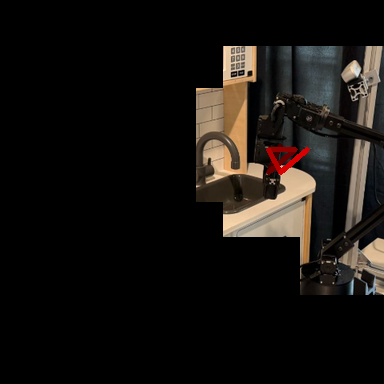

In [33]:
import cv2

def add_path_2d_to_img_alt_fast(
    image, points, line_size=1, circle_size=0, plot_lines=True
):
    img_out = image.copy()

    if np.all(points <= 1):
        points = points * image.shape[1]

    points = points.astype(int)
    path_len = len(points)

    # Generate gradient from dark red to bright red
    reds = np.linspace(64, 255, path_len).astype(int)
    colors = [tuple(int(r) for r in (r_val, 0, 0)) for r_val in reds]

    for i in range(path_len - 1):
        color = colors[i]
        if plot_lines:
            cv2.line(img_out, tuple(points[i]), tuple(points[i + 1]), color, line_size)
        if circle_size > 0:
            cv2.circle(
                img_out,
                tuple(points[i]),
                max(1, circle_size),
                color,
                -1,
                lineType=cv2.LINE_AA,
            )

    # Draw last point
    if circle_size > 0:
        cv2.circle(
            img_out,
            tuple(points[-1]),
            max(1, circle_size),
            colors[-1],
            -1,
            lineType=cv2.LINE_AA,
        )

    return img_out

import numpy as np
from vila_utils.utils.encode import scale_path
from vila_utils.utils.decode import get_path_from_answer, add_mask_2d_to_img

img = np.array(image)
h, w, c = img.shape

# extract path from answer
out = get_path_from_answer(outputs, prompt_type)

# scale path to image size

scaled_mask = None
if "mask" in prompt_type:
    min_in, max_in = np.zeros(2), np.array([w,h])
    min_out, max_out = np.zeros(2), np.ones(2)
    mask = out[1] if len(out) == 2 else out
    scaled_mask = scale_path(mask, min_in=min_out, max_in=max_out, min_out=min_in, max_out=max_in)

scaled_path = None
if "path" in prompt_type:
    min_in, max_in = np.zeros(2), np.array([w,h])
    min_out, max_out = np.zeros(2), np.ones(2)
    path = out[0] if len(out) == 2 else out
    scaled_path = scale_path(path, min_in=min_out, max_in=max_out, min_out=min_in, max_out=max_in)

if "mask" in prompt_type and scaled_mask is not None:
    img = add_mask_2d_to_img(img, scaled_mask, mask_pixels=int(h*0.15))
    # img = add_mask_2d_to_img(img, scaled_path, mask_pixels=30 if resize_crop else 10)

if "path" in prompt_type and scaled_path is not None:
    # img = add_path_2d_to_img(img, scaled_path, color=(255,0,0))#, cmap="inferno")
    img = add_path_2d_to_img_alt_fast(img, scaled_path, line_size=3, circle_size=0, plot_lines=True)

print("quest:", quest)
Image.fromarray(img)

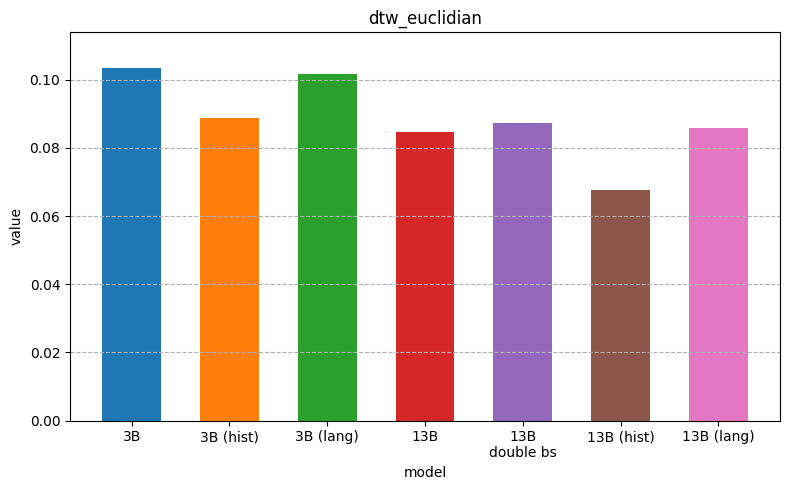

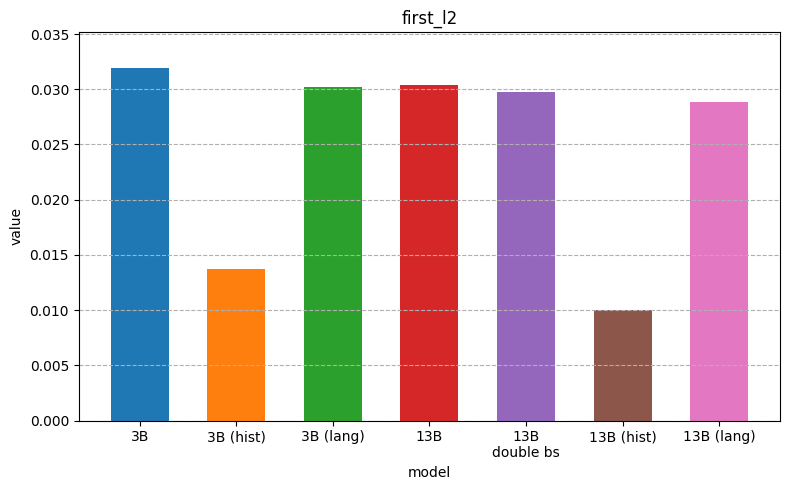

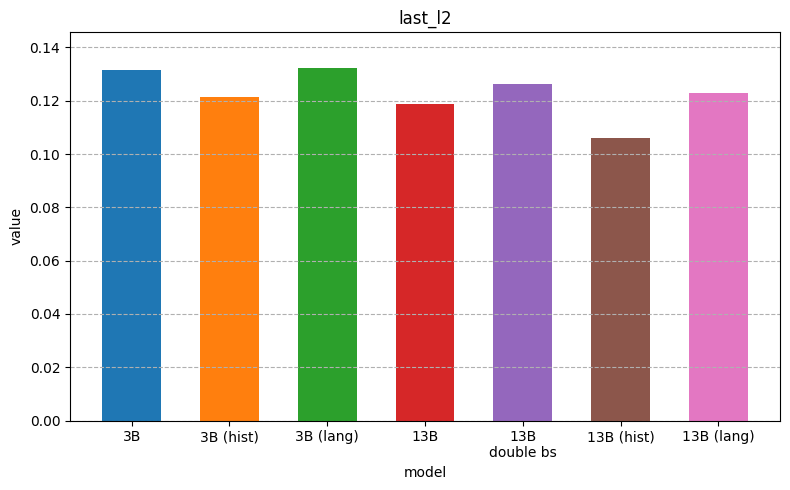

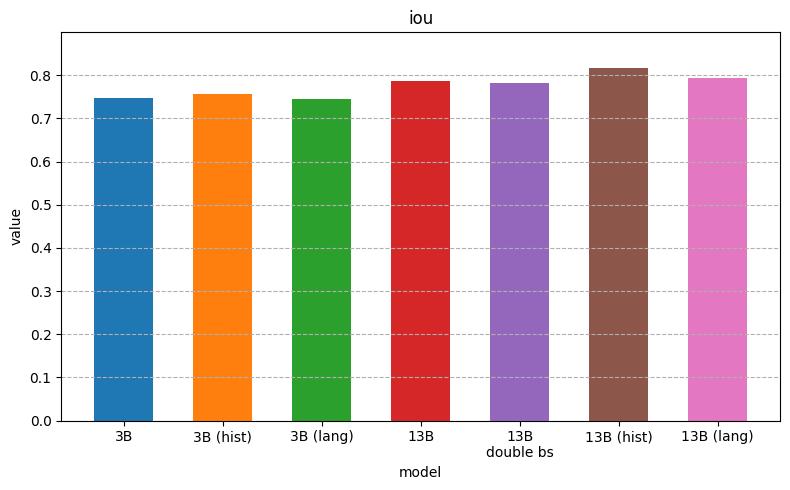

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
model_names = [
    # "NVILA_2B", # "nvila_2b_path_mask",
    # "VILA_3B", # "vila_3b_path_mask",
    # "NVILA_8B", # "nvila_8b_path_mask",
    # "VILA_13B", # "vila_13b_path_mask",

    "3B", # new
    "3B (hist)", # "vila_3b_path_mask",
    "3B (lang)", # "vila_3b_path_mask",

    "13B",
    "13B\ndouble bs",
    "13B (hist)",
    "13B (lang)",
    # "NVILA_2B (old)", # "nvila_2b_path_mask PREV NEW RESULTS",
    # "NVILA_3B (old)", # "vila_3b_path_mask PREV NEW RESULTS",
    # "NVILA_8B (old)", # "nvila_8b_path_mask PREV NEW RESULTS",

    # "nvila_2b_path_mask PREV RESULTS",
    # "vila_3b_path_mask PREV RESULTS",
    # "nvila_8b_path_mask PREV RESULTS",
    # "vila_13b_path_mask PREV RESULTS",


]
results = [
    # {'dtw_euclidian': 0.1694494635025215, 'first_l2': 0.07134161672118855, 'last_l2': 0.19967581465843215, 'iou': 0.5747018650355848},
    # {'dtw_euclidian': 0.10864983866681419, 'first_l2': 0.06322330749925437, 'last_l2': 0.12546103236718417, 'iou': 0.685327553631155},
    # {'dtw_euclidian': 0.14829701792037073, 'first_l2': 0.07083671457077642, 'last_l2': 0.17570708729822268, 'iou': 0.6312077476753832},
    # {'dtw_euclidian': 0.09132114159698235, 'first_l2': 0.060100818419623496, 'last_l2': 0.11860568798113337, 'iou': 0.7115718131364072},
    
    {'dtw_euclidian': 0.1035704302471311, 'first_l2': 0.031961395455141206, 'last_l2': 0.13136208750792117, 'iou': 0.7475734436907747},
    {'dtw_euclidian': 0.08867394971996359, 'first_l2': 0.01373631773192584, 'last_l2': 0.12133692785517773, 'iou': 0.7567442792485586},
    {'dtw_euclidian': 0.10181157158572533, 'first_l2': 0.030215502551339618, 'last_l2': 0.13241564873304518, 'iou': 0.7452934425312071},

    {'dtw_euclidian': 0.08470976539928982, 'first_l2': 0.030381783182686365, 'last_l2': 0.11889564322244696, 'iou': 0.7857567018832107},
    {'dtw_euclidian': 0.0873326157489899, 'first_l2': 0.029720857537540113, 'last_l2': 0.12643253282733075, 'iou': 0.7815710285427433},
    {'dtw_euclidian': 0.06778818035938342, 'first_l2': 0.010024637172231165, 'last_l2': 0.10601165765147465, 'iou': 0.8176071754377995},
    {'dtw_euclidian': 0.08596024217354473, 'first_l2': 0.028839548513174693, 'last_l2': 0.12301582229162028, 'iou': 0.7931883714493975},

    # {'dtw_euclidian': 0.18639047941219544, 'first_l2': 0.07368256176954437, 'last_l2': 0.20625138556454767, 'iou': 0.5200059519648347},
    # {'dtw_euclidian': 0.16770507223888773, 'first_l2': 0.07059119822911877, 'last_l2': 0.18993103063681338, 'iou': 0.5823198833703025},
    # {'dtw_euclidian': 0.1492438986477681, 'first_l2': 0.07043064740327598, 'last_l2': 0.1695204102292874, 'iou': 0.5748769190089118},

    # {'dtw_euclidian': 0.15346681927355854, 'first_l2': 0.0484519305473742, 'last_l2': 0.16395030230706653, 'iou': 0.5872054458280227},
    # {'dtw_euclidian': 0.13295070871465064, 'first_l2': 0.04551327958727518, 'last_l2': 0.14359874702043987, 'iou': 0.5949483348658591},
    # {'dtw_euclidian': 0.17383275667663106, 'first_l2': 0.051840275159304505, 'last_l2': 0.17008161816860448, 'iou': 0.5476303844055059},
    # {'dtw_euclidian': 0.14238298353638945, 'first_l2': 0.045739203195505194, 'last_l2': 0.135130529323302, 'iou': 0.6124320168885545}


]

# Extract metrics
metrics = list(results[0].keys())
metric_values = {metric: [res[metric] for res in results] for metric in metrics}
colors = plt.get_cmap('tab10')
# Plot each metric in a separate plot
for i, metric in enumerate(metrics):
    values = metric_values[metric]
    x = np.arange(len(model_names))
    bar_width = 0.6  # Wider bars for tighter spacing
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, values, width=bar_width, color=[colors(j) for j in x])
    # Format
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_title(f'{metric}')
    ax.set_ylabel('value')
    ax.set_xlabel('model')
    # Y-axis starts at 0
    ax.set_ylim(0, max(values) * 1.1)
    ax.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

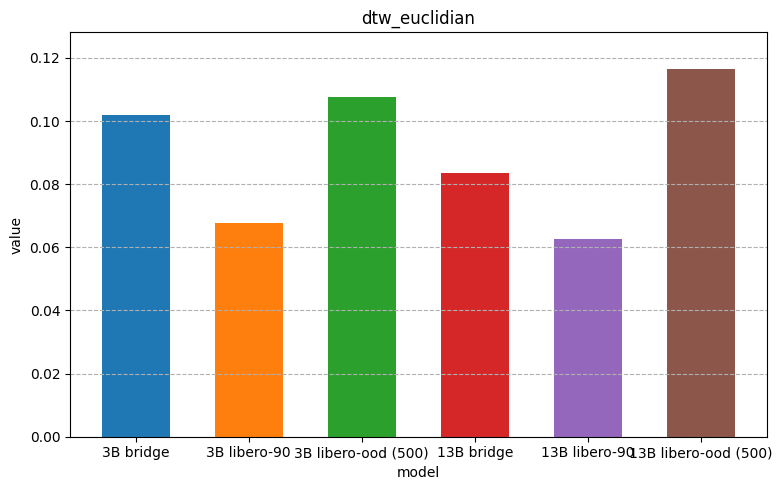

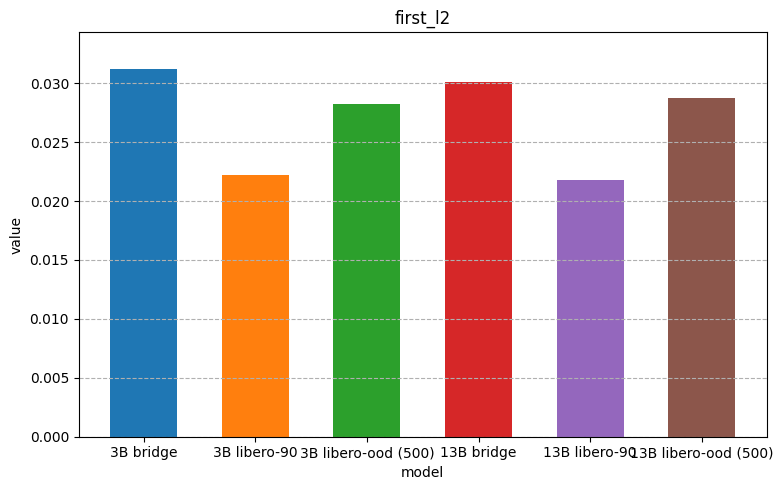

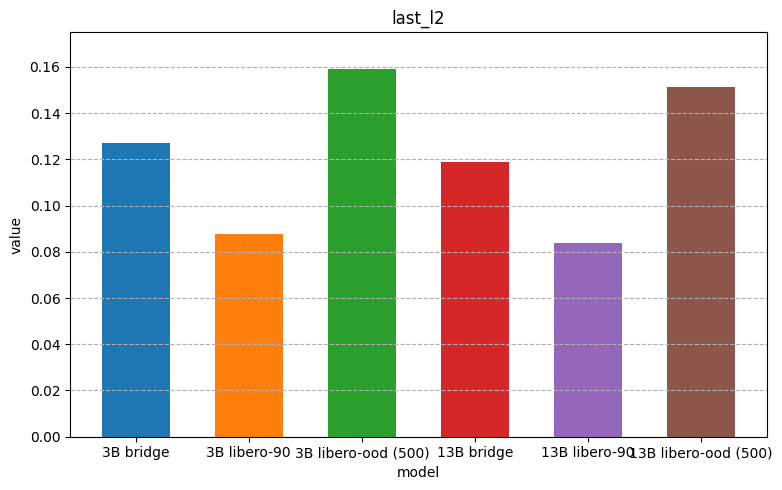

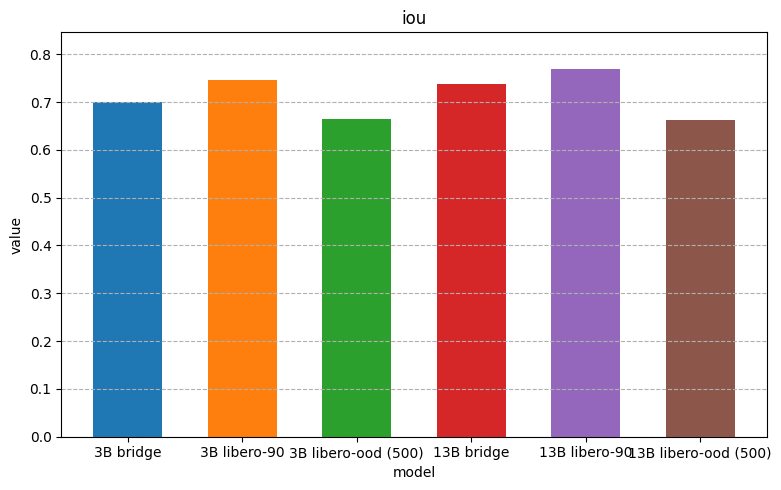

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
model_names = [
    "3B bridge",
    "3B libero-90",
    "3B libero-ood (500)",

    "13B bridge",
    "13B libero-90",
    "13B libero-ood (500)",

]
results = [
    {'dtw_euclidian': 0.1019867172923494, 'first_l2': 0.03120046810321275, 'last_l2': 0.12720403083137527, 'iou': 0.7000904002986874},
    {'dtw_euclidian': 0.06778167294759598, 'first_l2': 0.022186951449207376, 'last_l2': 0.08780632791403199, 'iou': 0.7453656516930338},
    {'dtw_euclidian': 0.10773498262605918, 'first_l2': 0.028225011738956585, 'last_l2': 0.15903486319904742, 'iou': 0.6638343289009099},

    {'dtw_euclidian': 0.08357067445307981, 'first_l2': 0.0300738591745304, 'last_l2': 0.1188347971863155, 'iou': 0.7370429976697616},
    {'dtw_euclidian': 0.06252671856717254, 'first_l2': 0.021787443490682526, 'last_l2': 0.0836044108753365, 'iou': 0.7688262600182062},
    {'dtw_euclidian': 0.11646149958682343, 'first_l2': 0.028725822935414452, 'last_l2': 0.1513073354104056, 'iou': 0.6619825395215146}
]

# Extract metrics
metrics = list(results[0].keys())
metric_values = {metric: [res[metric] for res in results] for metric in metrics}
colors = plt.get_cmap('tab10')
# Plot each metric in a separate plot
for i, metric in enumerate(metrics):
    values = metric_values[metric]
    x = np.arange(len(model_names))
    bar_width = 0.6  # Wider bars for tighter spacing
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, values, width=bar_width, color=[colors(j) for j in x])
    # Format
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_title(f'{metric}')
    ax.set_ylabel('value')
    ax.set_xlabel('model')
    # Y-axis starts at 0
    ax.set_ylim(0, max(values) * 1.1)
    ax.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()